In [91]:
import csv
import datetime
import time
import os
from selenium import webdriver

import matplotlib.pyplot as plt
import collections
from openpyxl import load_workbook

import math
import statistics
import numpy as np
import pandas as pd

import openpyxl
openpyxl.Workbook.encoding = "cp936"
pd.set_option('display.max_rows', 500)


In [200]:
def get_filename_from_folder(folder_path, ext=""):
    file_name_list = []
    for file_name in os.listdir(folder_path):
        name = os.path.join(folder_path + "/"+ file_name)
        
        # get file extension
        file_ext = os.path.splitext(file_name)[1]
        # if user give ext and the file extension is not the same, pass
        if ext and file_ext != ext:
            continue
        
        # os.rename(name, os.path.join(folder_path + "/"+ file_name[1:]))
#         
        file_name_list.append(name)
        
    return sorted(file_name_list)

def filename_process(target, filename_list):
    
    split_file_name = [ x.split("_") for x in filename_list]
    
    for i in split_file_name:
        try:
            ytr = i[1][1:]
            types = i[3]
            start = i[4]
            end = i[5].split(".")[0]
        
            if target == ytr:
                yield ytr, types, start, end
        except:
            pass

def get_file_by_ytr_and_date(ytr, types, start, filename_list):
    file_list = []
    for fytr, ftypes, fstart, fend in filename_process(ytr, filename_list):
        if fytr == ytr and ftypes == types and fstart == start:
            name = f"./yt_/{fytr}_單主題_{ftypes}_{fstart}_{fend}.xlsx"

            file_list.append(name)
    return file_list


def string_to_datetime(s):
    return datetime.datetime.strptime(s, '%Y/%m/%d')


# opview 資料（趨勢 和 好感度）
def get_ytrs_view_and_emotion_by_startdate(ytrs: list, startdate: str, enddate: str, filename_list_op: list):
    
    ytrs_view = []
    ytrs_emotion = []
    
    for ytr in ytrs: # iter each youtuber
        # read all views data
        op_view_data = collections.OrderedDict()
        for date in DATE:
            for filename in get_file_by_ytr_and_date(ytr, '趨勢', date, filename_list_op):
                wb = load_workbook(filename=filename)
                # op_view_data['name'] = ytr
                opview_wb = wb['日趨勢']
                for i in range(2, opview_wb.max_row+1):
                    day = opview_wb.cell(column=1, row=i).value
                    qty = opview_wb.cell(column=2, row=i).value
                    
                    if day >= startdate and day <= enddate:
                        op_view_data[day] = qty
        ytrs_view.append(op_view_data)

        # read all good bad data
        op_view_emotion = collections.OrderedDict(
            {'good': collections.OrderedDict(), 'bad': collections.OrderedDict()})
        for date in DATE:
            for filename in get_file_by_ytr_and_date(ytr, '情緒', date, filename_list_op):
                # opview 資料（情緒）
                wb = load_workbook(filename=filename)
                opview_wb = wb['日情緒趨勢']
                for i in range(2, opview_wb.max_row+1):

                    day = opview_wb.cell(column=1, row=i).value
                    good = opview_wb.cell(column=2, row=i).value
                    bad = opview_wb.cell(column=3, row=i).value
                    total = opview_wb.cell(column=4, row=i).value
                    if day >= startdate and day <= enddate:
                        op_view_emotion["good"][day] = good
                        op_view_emotion["bad"][day] = bad
        ytrs_emotion.append(op_view_emotion)

    return ytrs_view ,ytrs_emotion


# plot views and good/bad emotions
def plot_view_and_emotion(ytrs_view, ytrs_emotion, ytrs, stepsize=1, figsize=(19,4)):
    for view, emotion, name in zip(ytrs_view, ytrs_emotion, ytrs):
        print(name)
        fig, ax1 = plt.subplots(figsize=figsize)
        ax1.plot(view.values(), figure=fig,
                 linewidth=1, c='black', label="opview")
        ax1.plot(emotion["good"].values(), figure=fig,
                 linewidth=1, c='g', label="good")
        ax1.plot(emotion["bad"].values(), figure=fig,
                 linewidth=1, c='r', label="bad")
        plt.xticks(range(0, len(list(view.keys())), stepsize),
                       list(view.keys())[::stepsize], rotation=20)
        ax1.legend()


def get_news_filename_list_by_ytrs(ytrs, data_folder_path, include_news=["ettoday_keywords.csv", "apple_news.csv", "dcard.csv" "ettoday_tag.csv", "ptt.csv"]):
    filename_list_news_all = []

    for ytr in ytrs:
        print(ytr)
        ytr_news = []  # news list for each ytr
        filename_list_news = get_filename_from_folder(
            data_folder_path + ytr)
        for x in filename_list_news:
            if x.split('/')[-1] in include_news:
                ytr_news.append(x)
        filename_list_news_all.append(ytr_news)

    return filename_list_news_all


def get_news_list_by_filename_list(filename_list_news_et):
    news_list = []
    for filename_list in filename_list_news_et:  # iterate ytr
        news = []
        for filename in filename_list:
            with open(filename, encoding="utf-8") as f:
                reader = csv.reader(f)
                for idx, row in enumerate(reader):
                    # Source,Title,Link,Date,Summary,Text,Like

                    if idx == 0 or row == ['Source', 'Title', 'Link', 'Date', 'Summary', 'Text', 'Like']:
                        continue
                    Source = row[0]
                    Title = "".join(row[1].split())
                    Link = row[2]
                    Date = row[3].split(" ")[0].replace('-', '/')
                    Summary = "".join(row[4].split())
                    Text = row[5]

                    news.append({"source": Source, "title": Title, "link": Link,
                                 "date": Date, "summary": Summary, "text": Text})
        news_list.append(news)
    return news_list


def compare_news_list_and_event_list(multiply=3):
    print('單日大於', multiply, '倍過去七天的平均：')

    # event definition
    for view, emotion, name, news in zip(ytrs_view, ytrs_emotion, ytrs, news_list):
        
        print(name)
        # event definition
        data = [list(view.values())[0]] * 7
        data.extend(list(view.values()))

        count = 0
        event_list = []

        for i, d in enumerate(data[7:], start=7):
            seven_day = data[i-7:i]
            seven_day_avg = sum(seven_day)/7
            if d > multiply * seven_day_avg:
                day = list(view.keys())[i-7]
                event_list.append(day)
        print(event_list)

        # find news
        print('來源     事件日期      日期好壞比  新聞日期     新聞日期好壞比    新聞標題')
        for i in news:
            day_add = datetime.timedelta(days=2)
            try:
                news_date = string_to_datetime(i['date'])
                
            except:
                news_date = i['date'].split(" ")[0].replace("-", "/")
                news_date = string_to_datetime(news_date)

            for event in event_list:
                temp_event = event
                temp_view = view
                temp_emotion = emotion
                event_day = string_to_datetime(event)
                if news_date >= event_day and news_date <= event_day + day_add:
                    try:
                        print(i['source'], event_day.strftime('%Y-%m-%d'), ' ',
                            '%.2f' % (round(
                                emotion['good'][event] / emotion['bad'][event], 2)), '    ',
                            news_date.strftime('%Y-%m-%d'), '  '
                            '%.2f' % (round(
                                emotion['good'][i['date']] / emotion['bad'][i['date']], 2)), '       ',
                            i['title'])
                    except:
                        pass


def generate_ytr_name_list(filename="Youtuber名單 - 道歉.csv"):
    ytr_list = []
    with open(filename, 'r') as f:
        rows = csv.reader(f)
        for row in rows:
            if row[1] == "":
                pass
            if row[1] == "頻道(官方帳號)":
                continue
            ytr_name = []
            ytr_name.append(row[1].replace(
                "/", " ").replace("   ", " ").split("\n")[0])

            ytr_name.extend(row[3].replace("、", "\n").split("\n"))
            ytr_list.append(list(dict.fromkeys(ytr_name)))
    return ytr_list
                    


In [227]:
filename_list_op = get_filename_from_folder("./yt_", ".xlsx")
filename_list_op[0]

'./yt_/Ashly_單主題_來源_20191201_20201130.xlsx'

## opview plot

In [56]:
list(ytrs_view[0].keys())[::100]


['2019/12/01',
 '2020/03/10',
 '2020/06/18',
 '2020/09/26',
 '2021/01/04',
 '2021/04/14',
 '2021/07/23',
 '2021/10/31']

/Users/bobo/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


放火
Joeman
Toyz
NanaQ
呱吉


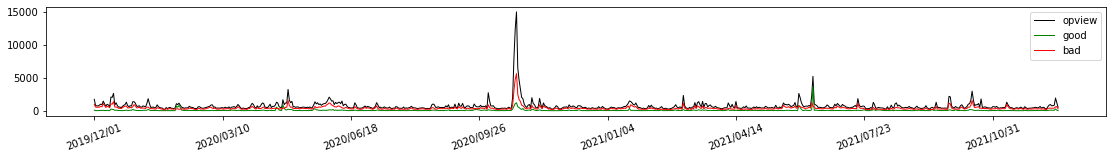

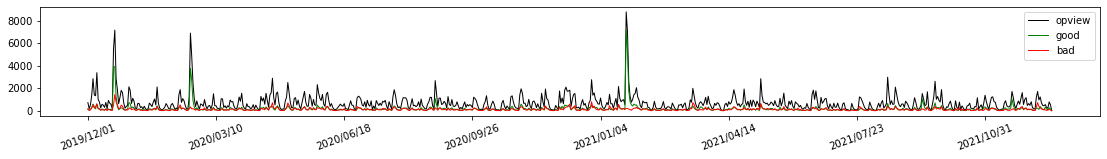

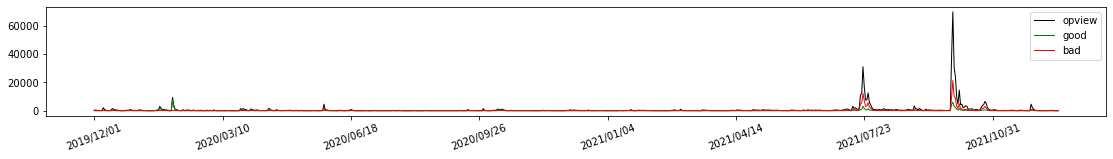

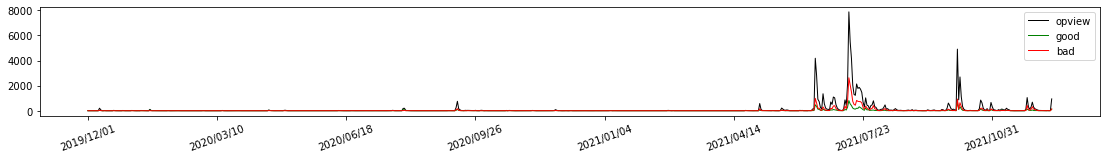

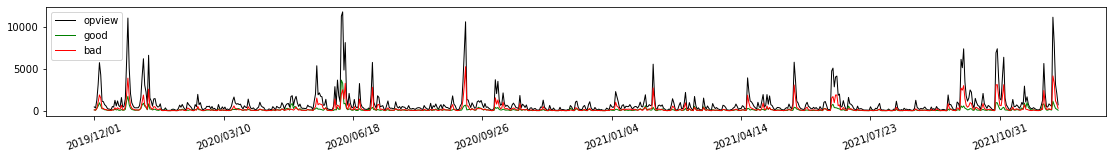

In [120]:
ytrs = ["放火", "Joeman", "Toyz", "NanaQ", "呱吉"]
DATA_FOLDER_PATH = "/Users/bobo/OneDrive - 台灣微軟/0. bobo/Codes/crawlers/data/"
DATE = ["20191201", "20201201"]
STARTDATE = "2019/10/12"
# STARTDATE = "20200201"
ENDDATE = "2022/11/16"
ytrs_view, ytrs_emotion = get_ytrs_view_and_emotion_by_startdate(
    ytrs, STARTDATE, ENDDATE, filename_list_op)
plot_view_and_emotion(ytrs_view, ytrs_emotion, ytrs, stepsize=100, figsize=(19,2))


## read news

In [5]:
ytrs = ["放火 Louis", "Joeman", "Toyz", "NanaQ", "呱吉"]
filename_list_news = get_news_filename_list_by_ytrs(ytrs, DATA_FOLDER_PATH, ["ettoday_keywords.csv", "apple_news.csv", "dcard.csv" "ettoday_tag.csv", "ptt.csv"])
news_list = get_news_list_by_filename_list(filename_list_news)
compare_news_list_and_event_list(multiply=3)

放火 Louis
Joeman
Toyz
NanaQ
呱吉
單日大於 3 倍過去七天的平均：
放火 Louis
['2020/10/22', '2020/10/23', '2020/10/24', '2020/10/25']
來源     事件日期      日期好壞比  新聞日期     新聞日期好壞比    新聞標題
apple_news 2020-10-24   0.23      2020-10-26   0.24         放火桃花劫後恢復影片更新「不會做任何傷害自己的事」
apple_news 2020-10-25   0.21      2020-10-26   0.24         放火桃花劫後恢復影片更新「不會做任何傷害自己的事」
apple_news 2020-10-25   0.21      2020-10-27   0.28         燒單車灼傷小學童放火國中生到案！惡行動機曝光
apple_news 2020-10-25   0.21      2020-10-27   0.28         放火桃花劫稱問心無愧「擔心會不會有人找我跟家人麻煩」
apple_news 2020-10-25   0.21      2020-10-27   0.28         為「放火」桃花劫互槓瘋男怒嗆烏鴉：你曝光後害他黑掉
apple_news 2020-10-25   0.21      2020-10-27   0.28         「生子無用」翁燒兒遊覽車
apple_news 2020-10-24   0.23      2020-10-26   0.24         老父怨「養子無路用」縱火燒子遊覽車兩子聲請保護令（台語片）
apple_news 2020-10-25   0.21      2020-10-26   0.24         老父怨「養子無路用」縱火燒子遊覽車兩子聲請保護令（台語片）
apple_news 2020-10-24   0.23      2020-10-26   0.24         全球聲援籲中釋放12港青
apple_news 2020-10-25   0.21      2020-10-26   0.24         全球聲援籲中釋放12港青
apple_news 

## calculate good bad

In [239]:
# get ytrs list from opview_xlsx
op_view_ytrs = sorted(list(set([x.replace("/", "_").split("_")[2]
                      for x in get_filename_from_folder("yt_", ".xlsx")])))

In [261]:
# read 工作表1 and turn name&subscribe to dict
ytr_data_dict = collections.OrderedDict()
with open("../Youtuber名單 - 工作表1_20220109.csv", 'r') as f:
    rows = csv.reader(f)
    for row in rows:
        if row[1] == "":
            pass
        if row[1] == "頻道(官方帳號)":
            continue
        # name
        ytr_name = []
        ytr_name.append(row[1].replace(
            "/", " ").replace("   ", " ").split("\n")[0])
        ytr_name.extend(row[3].replace("、", "\n").split("\n"))
        # category
        ytr_category = row[0]
        # subscriber
        subscribe = row[2].replace("萬", "")
        # sorry or not
        sorry = [True if row[5] == "✓" else False for x in range(1)][0]

        ytr_data_dict[ytr_name[0]] = {"ytr_name" : ytr_name, "ytr_category":ytr_category, "subscriber" : subscribe, "sorry" :sorry}

ytr_data_dict['龍龍LungLung']


{'ytr_name': ['龍龍LungLung', '龍龍', 'LungLung'],
 'ytr_category': '生活搞笑類',
 'subscriber': '35.8',
 'sorry': True}

In [262]:
# convert data to list
good_bad_list = [""] * len(op_view_ytrs)
ytr_channel_name_list = [""] * len(op_view_ytrs)
subscribe_list = [0] * len(op_view_ytrs)
category_list = [""] * len(op_view_ytrs)
sorry_list = [False] * len(op_view_ytrs)

for idx, ytr in enumerate(op_view_ytrs):
    # get subscriber and category from 工作表1
    for key in ytr_data_dict.keys():
        check_list = ytr_data_dict[key]['ytr_name']
        
        # 如果該ytr不在名單裡面，到下一輪
        if ytr in check_list:
            # subscriber
            subscribe_list[idx] = ytr_data_dict[key]['subscriber']
            # ytr category
            category_list[idx] = ytr_data_dict[key]['ytr_category']
            # channel name
            ytr_channel_name_list[idx] = ytr_data_dict[key]['ytr_name'][0]
            # sorry or not
            sorry_list[idx] = ytr_data_dict[key]['sorry']

    # get good or bad list from opview_emotion
    ytrs_view, ytrs_emotion = get_ytrs_view_and_emotion_by_startdate(
        [ytr], STARTDATE, ENDDATE, filename_list_op)
    g = np.array(list(ytrs_emotion[0]['good'].values()))
    b = np.array(list(ytrs_emotion[0]['bad'].values()))
    if (g > b).sum() > (g.shape[0]/2): # 如果好天大於壞天的數量過半，就是好寶寶，反之壞寶寶
        good_bad_list[idx] = "good"
        # print(f"{ytr.ljust(30)}{'good'}")
    else:
        good_bad_list[idx] = "bad"
        # print(f"{ytr.ljust(30)}{'bad'}")





/Users/bobo/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [263]:
op_view_ytrs[3]


'Hello Catie'

In [268]:
df = pd.DataFrame(
    [op_view_ytrs, ytr_channel_name_list, good_bad_list, subscribe_list, category_list, sorry_list])
df = df.T.set_axis(["opview", "ytr_crawl", "g/b", "sub", "category", "sorry"], axis=1)
display(df.head())
df.to_csv("../ytr_data.csv")

,opview,ytr_crawl,g/b,sub,category,sorry
0,Ashly,尼克&ASHLY,good,56,生活搞笑類,True
1,Dinter,Dinter,bad,75.7,電玩實況類,True
2,Dr.Ivan,Dr. Ivan 6,bad,50.6,知識教育類,True
3,Hello Catie,Hello Catie,bad,109,美妝穿搭類,True
4,HowFun,HowFun,bad,141,生活搞笑類,True


In [272]:
ytr_data_df = pd.read_csv(
    '../ytr_data.csv', names=["opview", "ytr_crawl", "g/b", "sub", "category", "sorry"], header=0)
ytr_data_df

,opview,ytr_crawl,g/b,sub,category,sorry
0,Ashly,尼克&ASHLY,good,56.0,生活搞笑類,True
1,Dinter,Dinter,bad,75.7,電玩實況類,True
2,Dr.Ivan,Dr. Ivan 6,bad,50.6,知識教育類,True
3,Hello Catie,Hello Catie,bad,109.0,美妝穿搭類,True
4,HowFun,HowFun,bad,141.0,生活搞笑類,True
5,Joeman,Joeman,good,219.0,生活搞笑類,True
6,NanaQ,NanaQ,bad,11.8,生活搞笑類,True
7,Pan Piano,NaN,good,0.0,NaN,False
8,Toyz,Toyz,bad,68.9,電玩實況類,True
9,heyitsmindy,heyitsmindy,bad,18.3,美妝穿搭類,True


In [93]:
# read ytr_crawl (ytr select previously)
ytr_df = pd.read_csv("../ytr_crawl.csv", header=None, sep="\n")[0].str.split(',',expand=True)
ytr_df.head()

,0,1,2,3,4,5
0,阿滴英文,阿滴,都省瑞,None,None,None
1,啾啾鞋,None,None,None,None,None
2,亮生活 Bright Side,亮生活,None,None,None,None
3,理科太太,陳映彤,None,None,None,None
4,Taiwan Bar,台灣吧,None,None,None,None


In [283]:
already = ["Dinter","Dr. Ivan 6","Hello Catie","HowFun","Jinnytty 企鵝妹 윰찌","Joeman","NanaQ","Stand up, Brian! 博恩站起來！","Toyz","VITO維特","WACKYBOYS 反骨男孩","heyitsmindy","一隻阿圓 I am CIRCLE","上班不要看 NSFW","丹妮婊姐星球","古娃娃WawaKu","呱吉","大蛇丸","大麻煩","孫安佐","愛莉莎莎 Alisasa","放火 Louis","木曜4超玩","波特王 Potter King","滴妹","理科太太","瑀熙 Yuci","白癡公主","眾量級CROWD","米砂Misa","統神大戲院","綠眼鏡Punk","聖結石Saint","蔡桃貴 蔡阿嘎二伯's Family","見習網美小吳","許藍方博士 Dr. Gracie","谷阿莫","鍾明軒","阿滴英文","阿神","阿翰po影片","黃大謙","黃氏兄弟","鼻地大師國動-張葦航","龍龍LungLung"]
out_filename = "../test.csv"
with open(out_filename, 'w') as out_file:
    for i in already:
        try:
            out_file.write("、".join(list(set(ytr_data_dict[i]["ytr_name"]))) + "\n")
        except:
            out_file.write("." + "\n")


In [284]:
not_already = ["Ashly", "Pan Piano", "史丹利", "奎丁", "孫生", "尼克", "我愛貓大",
               "搞神馬", "攝徒日記", "本本", "牛排生活", "眼球中央電視台", "艾瑞絲", "這批太純", "鄭茵聲", "酷炫"]
out_filename = "../test.csv"
with open(out_filename, 'w') as out_file:
    for i in not_already:
        try:
            out_file.write(
                "、".join(list(set(ytr_data_dict[i]["ytr_name"]))) + "\n")
        except:
            out_file.write("." + "\n")


